In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-4.3.0:
  Successfully uninstalled Pillow-4.3.0
     |████████████████████████████████| 2.0MB 4.9MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


4.3.0


In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
# Import the necessary packages:
import cv2
import glob
from PIL import Image  # Python Image Library for image processing
import matplotlib.pyplot as plt  # Plotting
import numpy as np  # Numerical computation
import torch  # Neural network computation
from torch import optim  # optimizer to minimize the loss function
from torchvision import transforms, models  # Transformations on images and pre-trained models
import os, os.path  # To count the number of image files

import PIL
print(PIL.PILLOW_VERSION)

4.3.0


In [4]:
styleTransferModel = models.vgg19(pretrained=True).features
for params in styleTransferModel.parameters():
	params.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:28<00:00, 20.5MB/s]


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

styleTransferModel.to(device)

Running on GPU


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
# Load the content and style images:
def load_image(image_path, max_size=480, shape=None):
    # Load in an image and make sure that it is <= 400 pixels in the X-Y dimension:
    # Convert the image to RGB:
    image = Image.open(image_path).convert('RGB')

    # Resize the image as a large image will slow down processing:
    if max(image.size) > max_size:
        img_size = max_size
    else:
        img_size = max(image.size)

    if shape is not None:
        img_size = shape

    img_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])
    # Discard the transparent alpha channel (that's the :3) and add the batch dimension:
    image = img_transform(image)[:3, :, :].unsqueeze(0)

    return image

In [0]:
# CONTENT AND STYLE FEATURES:
# Map the layer names to the names given in the paper:
def get_features(image, model, layers=None):
    # Run an image forward through a model and get the features for a set of layers:

    # Layers for the content and style representation of an image:
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content representation
                  '28': 'conv5_1',}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model:
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [0]:
# GRAM MATRIX:
# Define the gram matrix of the tensor:
def gram_matrix(tensor):
    # Calculate the Gram Matrix of a given tensor:
    # Get the batch_size, depth, height and width of the image:
    batch_size, depth, height, width = tensor.size()
    #(Sample tensor shape : torch.Size([1, 64, 400, 592]))
    # Here, batch_size = 1, depth = 64, height = 400, width = 592
    
    # Vectorize the input image tensor and add all the feature maps:
    tensor = tensor.view(depth, height * width)
    # Transpose the image tensor:
    tensor_t = tensor.t()
    # Compute the gram matrix by multiplying the matrix by its transpose:
    gram = torch.mm(tensor, tensor_t)

    # Return the gram matrix:
    return gram

In [0]:
# Function to un-normalize an image and convert from a Tensor image to a NumPy image for display or writing to disk:
def img_convert(tensor):
    # Display a tensor as an image:

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [0]:
!git clone https://github.com/pathak22/pyflow.git

fatal: destination path 'pyflow' already exists and is not an empty directory.


In [7]:
cd pyflow/

/content/drive/My Drive/ZFH/pyflow


In [0]:
!python setup.py build_ext -i

running build_ext


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# from __future__ import unicode_literals
import time
import argparse
import pyflow

def optical_flow(Image1, Image2, Image1_index, Image2_index):
  # parser = argparse.ArgumentParser(
  #     description='Demo for python wrapper of Coarse2Fine Optical Flow')
  # parser.add_argument(
  #     '-viz', dest='viz', action='store_true',
  #     help='Visualize (i.e. save) output of flow.')
  # args = parser.parse_args()

  # im1 = np.array(Image1)
  # im2 = np.array(Image2)
  # im1 = im1.astype(float) / 255.
  # im2 = im2.astype(float) / 255.
  im1 = np.array(Image1, order='C').astype(float)
  im2 = np.array(Image2, order='C').astype(float)

  # Flow Options:
  alpha = 0.012
  ratio = 0.75
  minWidth = 20
  nOuterFPIterations = 7
  nInnerFPIterations = 1
  nSORIterations = 30
  colType = 0  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))

  s = time.time()
  u, v, im2W = pyflow.coarse2fine_flow(
      im1, im2, alpha, ratio, minWidth, nOuterFPIterations, nInnerFPIterations,
      nSORIterations, colType)
  e = time.time()
  # print('Time Taken: %.2f seconds for image of size (%d, %d, %d)' % (
  #     e - s, im1.shape[0], im1.shape[1], im1.shape[2]))
  flow = np.concatenate((u[..., None], v[..., None]), axis=2)
  np.save('../flow/flow_matrix/outFlow_%s_%s.npy' %(Image1_index, Image2_index), flow)

  hsv = np.zeros(im1.shape, dtype=np.uint8)
  hsv[:, :, 0] = 255
  hsv[:, :, 1] = 255
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang * 180 / np.pi / 2
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  cv2.imwrite('../flow/outFlow_%s_%s.png' %(Image1_index, Image2_index), rgb)
  im_warped = im2W[:, :, ::-1] * 255
  cv2.imwrite('../flow/Warped_%s_%s.jpg' %(Image1_index, Image2_index), im_warped)

  return flow, im_warped

In [0]:
input_frames_length = len([name for name in os.listdir('../input_content_frames') if os.path.isfile(os.path.join('../input_content_frames', name))])
frame_interval = (1,2,4)
# for i in range(1, input_frames_length):
#   del_1, del_2 = optical_flow(img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i))), img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i+1))), str(i), str(i+1))
#   print('Forward flow from %d to %d completed!' %(i, i+1))
# for i in range(input_frames_length, 1, -1):
#   del_1, del_2 = optical_flow(img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i))), img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i-1))), str(i), str(i-1))
#   print('Backward flow from %d to %d completed!' %(i, i-1))
for frame in frame_interval:
  for i in range(1, input_frames_length+1-frame):
    del_1, del_2 = optical_flow(img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i))), img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i+frame))), str(i), str(i+frame))
    print('Forward flow from %d to %d completed!' %(i, i+frame))
  for i in range(input_frames_length, frame, -1):
    del_1, del_2 = optical_flow(img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i))), img_convert(load_image('../input_content_frames/frame_%s.jpg' %str(i-frame))), str(i), str(i-frame))
    print('Backward flow from %d to %d completed!' %(i, i-frame))

In [0]:
def warped_flow_and_pixel_weight(Image1_index, Image2_index):
  backward_flow = np.load('../flow/flow_matrix/outFlow_%s_%s.npy' %(Image2_index, Image1_index))
  h, w, _ = backward_flow.shape
  coordinate = np.rint(backward_flow + 
                       np.concatenate((np.repeat(np.arange(h)+1, w).reshape(h,w,1), 
                                       np.tile(np.arange(w)+1, h).reshape(h,w,1)), axis=2))
  flow = []
  forward_flow = np.load('../flow/flow_matrix/outFlow_%s_%s.npy' %(Image1_index, Image2_index))
  for i in range(coordinate.shape[0]):
    for j in range(coordinate.shape[1]):
      x, y = coordinate[i,j]
      flow.append(forward_flow[min(h-1,max(0,int(x))),min(w-1,max(0,int(y)))])
  warped_flow = np.array(flow).reshape(h,w,-1)
  np.save('../flow/flow_matrix/outFlow_%s_%s_warped.npy' %(Image1_index, Image2_index), warped_flow)
  disocclusion = np.square(np.linalg.norm(warped_flow + backward_flow, axis=2)) - 0.01*(np.square(np.linalg.norm(warped_flow, axis=2))+np.square(np.linalg.norm(backward_flow, axis=2))) - 0.5 > 0
  motion_boundary = np.square(np.gradient(backward_flow, axis=2)[:,:,0])+np.square(np.gradient(backward_flow, axis=2)[:,:,1]) - 0.01*np.square(np.linalg.norm(backward_flow, axis=2)) - 0.002 > 0
  np.save('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image1_index, Image2_index), (~(disocclusion + motion_boundary)).astype(int))

In [0]:
frame_interval = (1,2,4)
for frame in frame_interval:
  for i in range(1, input_frames_length+1-frame):
    warped_flow_and_pixel_weight(i, i+frame)
    print('Warped flow and pixel weigt between %d and %d completed!' %(i, i+frame))

In [0]:
def long_pixel_weight(Image2_index):
  if Image2_index == 2:
    c_iminus1_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index), c_iminus1_i)
  elif Image2_index == 3:
    c_iminus1_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index), c_iminus1_i)
    c_iminus2_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index), np.maximum(c_iminus2_i - c_iminus1_i, np.zeros(c_iminus1_i.shape)))
  elif Image2_index == 4:
    c_iminus1_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index), c_iminus1_i)
    c_iminus2_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index), np.maximum(c_iminus2_i - c_iminus1_i, np.zeros(c_iminus1_i.shape)))
  else:
    c_iminus1_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-1, Image2_index), c_iminus1_i)
    c_iminus2_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-2, Image2_index), np.maximum(c_iminus2_i - c_iminus1_i, np.zeros(c_iminus1_i.shape))) 
    c_iminus4_i = np.load('../flow/flow_matrix/pixel_weight_%s_%s.npy' %(Image2_index-4, Image2_index))
    np.save('../flow/flow_matrix/long_pixel_weight_%s_%s.npy' %(Image2_index-4, Image2_index), np.maximum(c_iminus4_i - c_iminus2_i - c_iminus1_i, np.zeros(c_iminus1_i.shape)))

In [0]:
for frame in range(2, input_frames_length+1):
  long_pixel_weight(frame)
  print('Long pixel weights for frame %d completed!' %frame)

In [0]:
def warp_flow(Image1_index, Image2_index):
  flow = np.load('../flow/flow_matrix/outFlow_%s_%s_warped.npy' %(Image1_index, Image2_index))
  Image1 = img_convert(load_image('../output_style_transferred_frames/st_frame_%d.jpg' %Image1_index))
  im1 = np.array(Image1, order='C').astype(float)
  h, w = flow.shape[:2]
  flow = -flow
  flow[:,:,0] += np.arange(w)
  flow[:,:,1] += np.arange(h)[:,np.newaxis]
  flow = 2*flow/(flow.max(axis=(0,1)) - flow.min(axis=(0,1)))-1
  warped_frame = torch.nn.functional.grid_sample(torch.from_numpy(im1)[np.newaxis, :].permute(0, 3, 1, 2), torch.from_numpy(flow)[np.newaxis, :])
  plt.imsave('../input_content_frames/warped/frame_%s_%s_warped.jpg' %(Image1_index, Image2_index), warped_frame.permute(0, 2, 3, 1).squeeze().numpy())
  # return warped_frame.float()

In [0]:
def apply_style_transfer(content_img_dir, style_img_dir, style_img_name, output_img_dir):
    content_image_count = 1
    # style_image_count = 1

    # Retrieve the total number of content image frames and style frames:
    num_content_imgs = len([name for name in os.listdir('../%s' %content_img_dir) if os.path.isfile(os.path.join('../', content_img_dir, name))])
    #num_content_imgs = 5
    #num_style_imgs = len([name for name in os.listdir(style_img_dir) if os.path.isfile(os.path.join(style_img_dir, name))])
    # Divide the style images equally among the input frames:
    #frames_with_current_style = num_content_imgs // (num_style_imgs - 1)

    # Since there are 249 frames in the test video, you can use for loop, 
    # but prefer using while to avoid using magic numbers (hardcoding)
    while(content_image_count <= 27):
    #for i in range(1, 250):
        # Load in the content and style images and move them to the GPU if available:
        content_image = load_image('../' + content_img_dir + '/frame_' + str(content_image_count) + '.jpg').to(device)
        # if(content_image_count % frames_with_current_style == 0):
        #     style_image_count += 1

        style_image = load_image('../' + style_img_dir + '/' + style_img_name, shape=content_image.shape[-2:]).to(device)

        # Retrieve the features:
        content_features = get_features(content_image, styleTransferModel)
        style_features = get_features(style_image, styleTransferModel)

        # Calculate the gram matrix for each of our style representations:
        style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

        # We create a 'target image'. Note that, we are starting with the content image
        # and cloning it instead of creating an image with white filter:
        # We want to update our image based on the total loss and so we will turn on the gradients:
        if content_image_count == 1:
          target_image = load_image('../output_style_transferred_frames_iid/st_frame_%d.jpg' % content_image_count, shape=content_image.shape[-2:]).to(device)
          target_image = target_image.clone().requires_grad_(True).to(device)
        else:
          warp_flow(content_image_count-1, content_image_count)
          if content_image_count-2 > 0:
            warp_flow(content_image_count-2, content_image_count)
          if content_image_count-4 > 0:
            warp_flow(content_image_count-4, content_image_count)
          # target_image = content_image.clone().requires_grad_(True).to(device)
          target_image = load_image('../output_style_transferred_frames_iid/st_frame_%d.jpg' % content_image_count, shape=content_image.shape[-2:]).to(device)
          target_image = target_image.clone().requires_grad_(True).to(device)

        # LOSS AND WEIGHTS:
        # We assign weights for each style layer. Weighting earlier layers more will result in *larger* style artifacts:
        # Notice we are excluding `conv4_2`, i.e. our content representation:
        style_weights = {'conv1_1': 0.25,  # More style will come from earlier layers as they are weighted more
                         'conv2_1': 0.25,
                         'conv3_1': 0.25,
                         'conv4_1': 0.25,
                         'conv5_1': 0}  # Less style from later layers

        content_weight = 50  # alpha
        style_weight = 150  # beta, 1e6 = 1000000.0
        longterm_weight = 750 # gamma

        # Iteration hyperparameters:
        # Update the target image (as we update the model.parameters() in the classifiers):
        optimizer = optim.Adam([target_image], lr=0.01)
        
        for ii in range(1, 2):
            # Get the features from the target image:
            target_features = get_features(target_image, styleTransferModel)
            
            # 1. Calculate the content loss:
            batch_size, depth, height, width = content_features['conv4_1'].shape
            content_loss = torch.mean((target_features['conv4_1'] - content_features['conv4_1']) ** 2)
            
            # 2. Calculate the style loss:
            style_loss = 0
            # iterate through each style layer and add to the style loss:
            for layer in style_weights:
                # Get the "target" style representation for the layer:
                target_feature = target_features[layer]
                batch_size, depth, height, width = target_feature.shape

                # Calculate the target gram matrix:
                target_gram = gram_matrix(target_feature)

                # Get the "style" from the style gram matrices computed earlier:
                style_gram = style_grams[layer]

                # the style loss for one layer, weighted appropriately:
                layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

                # Add to the style loss:
                style_loss += layer_style_loss / (depth * height * width)

            # 3. Calculate the long-term temporal loss:
            longterm_loss = 0
            if content_image_count == 2:
              batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
              temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).to(device))**2) * 
                                        (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-1, content_image_count))[:,:,np.newaxis], 
                                                                    depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
              longterm_loss += temporal_loss
            if ((content_image_count == 3) | (content_image_count == 4)):
              batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
              for frame_gap in (1,2):
                temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-frame_gap, content_image_count)).to(device))**2) * 
                                        (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-frame_gap, content_image_count))[:,:,np.newaxis], 
                                                                    depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
                longterm_loss += temporal_loss
            if content_image_count > 4:
              batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
              for frame_gap in (1,2,4):
                temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-frame_gap, content_image_count)).to(device))**2) * 
                                        (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-frame_gap, content_image_count))[:,:,np.newaxis], 
                                                                    depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
                longterm_loss += temporal_loss

            # Calculate the total loss:
            total_loss = content_weight * content_loss + style_weight * style_loss + longterm_weight * longterm_loss
            print("Frame %s Total loss: " %content_image_count, total_loss.item())

        print("completed style transfer on image: ", content_image_count)
        content_image_count += 1
        # if(content_image_count <= 250):
        #     continue

In [62]:
content_image_count = 1
content_image = load_image('../input_content_frames/frame_1.jpg')
content_img_dir = 'input_content_frames'
num_content_imgs = len([name for name in os.listdir('../%s' %content_img_dir) if os.path.isfile(os.path.join('../', content_img_dir, name))])
longterm_weight = 750 # gamma
content_weight = 50  # alpha
style_weight = 150

tot_loss = []
temp_loss = []

while(content_image_count <= num_content_imgs):
    content_image = load_image('../' + content_img_dir + '/frame_' + str(content_image_count) + '.jpg').to(device)
    style_image = load_image('../' + 'input_style_frames' + '/' + 'style_3.jpg', shape=content_image.shape[-2:]).to(device)
    target_image = load_image('../output_style_transferred_frames/st_frame_%d.jpg' % content_image_count, shape=content_image.shape[-2:]).to(device)
    #target_image = load_image('../output_frames_with_temporal/st_frame_%d.jpg' % content_image_count, shape=content_image.shape[-2:]).to(device)

    content_features = get_features(content_image, styleTransferModel)
    style_features = get_features(style_image, styleTransferModel)
    target_features = get_features(target_image, styleTransferModel)
    
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    style_weights = {'conv1_1': 0.25,'conv2_1': 0.25,'conv3_1': 0.25,'conv4_1': 0.25,'conv5_1': 0} 

    # 1. Calculate the content loss:
    batch_size, depth, height, width = content_features['conv4_1'].shape
    content_loss = torch.mean((target_features['conv4_1'] - content_features['conv4_1']) ** 2)

    style_loss = torch.tensor(0.)
    # iterate through each style layer and add to the style loss:
    for layer in style_weights:
        # Get the "target" style representation for the layer:
        target_feature = target_features[layer]
        batch_size, depth, height, width = target_feature.shape

        # Calculate the target gram matrix:
        target_gram = gram_matrix(target_feature)

        # Get the "style" from the style gram matrices computed earlier:
        style_gram = style_grams[layer]

        # the style loss for one layer, weighted appropriately:
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

        # Add to the style loss:
        style_loss += layer_style_loss / (depth * height * width)

    # 3. Calculate the long-term temporal loss:
    longterm_loss = torch.tensor(0.)
    if content_image_count == 2:
      batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
      temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).to(device))**2) * 
                                (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-1, content_image_count))[:,:,np.newaxis], 
                                                            depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
      longterm_loss += temporal_loss
    if ((content_image_count == 3) | (content_image_count == 4)):
      batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
      for frame_gap in (1,2):
        temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-frame_gap, content_image_count)).to(device))**2) * 
                                (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-frame_gap, content_image_count))[:,:,np.newaxis], 
                                                            depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
        longterm_loss += temporal_loss
    if content_image_count > 4:
      batch_size, depth, height, width = load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-1, content_image_count)).shape
      for frame_gap in (1,2,4):
        temporal_loss = torch.sum(((target_image - load_image('../' + content_img_dir + '/warped/frame_%d_%d_warped.jpg' %(content_image_count-frame_gap, content_image_count)).to(device))**2) * 
                                (torch.from_numpy(np.repeat(np.load('../flow/flow_matrix/long_pixel_weight_%d_%d.npy' %(content_image_count-frame_gap, content_image_count))[:,:,np.newaxis], 
                                                            depth, axis=2)).to(device).unsqueeze(0).permute(0,3,1,2))) / (depth * height * width)
        longterm_loss += temporal_loss

    tot_loss.append((longterm_loss*longterm_weight+content_loss*content_weight+style_loss*style_weight).item()) 
    temp_loss.append(longterm_loss.item()*longterm_weight)   

    print("completed style transfer on image: ", content_image_count)
    content_image_count += 1

completed style transfer on image:  1
completed style transfer on image:  2
completed style transfer on image:  3
completed style transfer on image:  4
completed style transfer on image:  5
completed style transfer on image:  6
completed style transfer on image:  7
completed style transfer on image:  8
completed style transfer on image:  9
completed style transfer on image:  10
completed style transfer on image:  11
completed style transfer on image:  12
completed style transfer on image:  13
completed style transfer on image:  14
completed style transfer on image:  15
completed style transfer on image:  16
completed style transfer on image:  17
completed style transfer on image:  18
completed style transfer on image:  19
completed style transfer on image:  20
completed style transfer on image:  21
completed style transfer on image:  22
completed style transfer on image:  23
completed style transfer on image:  24
completed style transfer on image:  25
completed style transfer on image:

FileNotFoundError: ignored

In [0]:
total_loss_dep = tot_loss
temp_loss_dep = temp_loss

In [0]:
temp_loss_ind = temp_loss
total_loss_ind = tot_loss

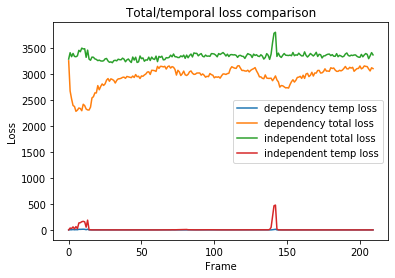

In [66]:
plt.plot(temp_loss_dep[:210], label='dependency temp loss')
plt.plot(total_loss_dep[:210], label='dependency total loss')
plt.plot(total_loss_ind[:210], label='independent total loss')
plt.plot(temp_loss_ind[:210], label='independent temp loss')
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.title('Total/temporal loss comparison')
plt.legend()
plt.show()

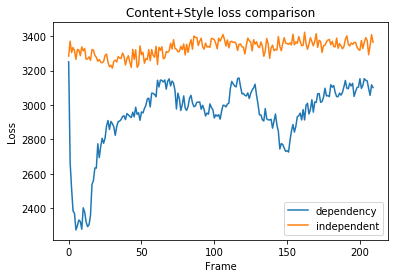

In [69]:
plt.plot(np.array(total_loss_dep[:210])-np.array(temp_loss_dep[:210]), label='dependency')
plt.plot(np.array(total_loss_ind[:210])-np.array(temp_loss_ind[:210]), label='independent')
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.title('Content+Style loss comparison')
plt.legend()
plt.show()

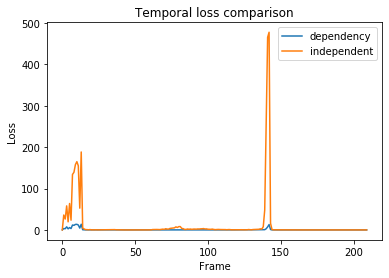

In [70]:
plt.plot(temp_loss_dep[:210], label='dependency')
plt.plot(temp_loss_ind[:210], label='independent')
plt.xlabel('Frame')
plt.ylabel('Loss')
plt.title('Temporal loss comparison')
plt.legend()
plt.show()

In [0]:
# Apply style transfer on the input frames:
apply_style_transfer('input_content_frames', 'input_style_frames', 'style_3.jpg', 'output_style_transferred_frames')

Frame 1 Total loss:  3284.895751953125
completed style transfer on image:  1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Frame 2 Total loss:  3407.27392578125
completed style transfer on image:  2
Frame 3 Total loss:  3331.281982421875
completed style transfer on image:  3
Frame 4 Total loss:  3393.09326171875
completed style transfer on image:  4
Frame 5 Total loss:  3335.939208984375
completed style transfer on image:  5
Frame 6 Total loss:  3329.58447265625
completed style transfer on image:  6
Frame 7 Total loss:  3346.946533203125
completed style transfer on image:  7
Frame 8 Total loss:  3453.13330078125
completed style transfer on image:  8
Frame 9 Total loss:  3426.146728515625
completed style transfer on image:  9
Frame 10 Total loss:  3495.65380859375
completed style transfer on image:  10
Frame 11 Total loss:  3479.44482421875
completed style transfer on image:  11
Frame 12 Total loss:  3483.740966796875
completed style transfer on image:  12
Frame 13 Total loss:  3318.55322265625
completed style transfer on image:  13
Frame 14 Total loss:  3456.966796875
completed style transfer on image:  14

In [0]:
# Convert the final images to video:
def img_to_video(st_output_dir, output_video_name):
    img = cv2.imread('../' + st_output_dir + '/st_frame_1.jpg')
    height, width, layers = img.shape
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    video = cv2.VideoWriter('../output_processed_video/%s.avi' %output_video_name, fourcc, 25, (width, height))
    for i in range(1, len([name for name in os.listdir('../%s' %st_output_dir) if os.path.isfile(os.path.join('../', st_output_dir, name))])+1):
        video.write(cv2.imread('../' + st_output_dir + '/st_frame_' + str(i) + '.jpg'))

    cv2.destroyAllWindows()
    video.release()

In [0]:
img_to_video('output_style_transferred_frames', 'style_transfered_video')